<a href="https://colab.research.google.com/github/paulkroe/simulate-bidped/blob/main/dm_biped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs and Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

print('Installing dm_control...')
!pip install -q dm_control>=1.0.35

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del pixels, suite

!echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

FileNotFoundError: [Errno 2] No such file or directory: 'nvidia-smi'

In [3]:
# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [4]:
# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [5]:
!pip install stable-baselines3 gymnasium dm_control

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 7.8 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

# Loading the model

In [6]:
# camera mode: 0 (fixed), 1 (following)
camera_mode = 1

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

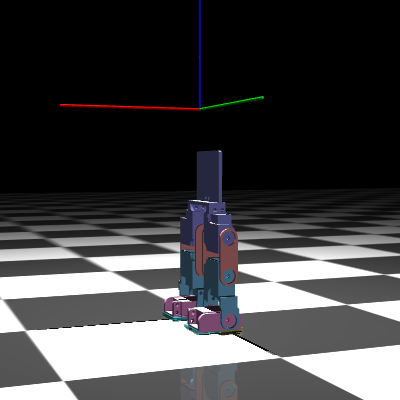

In [25]:
import PIL.Image
import numpy as np
from dm_control import composer, mjcf
from dm_control.locomotion.arenas import floors
from scipy.spatial.transform import Rotation as R
from dm_control.composer.observation import observable

class Biped(composer.Entity):
    def _build(self, xml_path="drive/MyDrive/biped/model.xml"):
        self._mjcf_model = mjcf.from_path(xml_path)

    @property
    def mjcf_model(self):
        return self._mjcf_model

    def _build_observables(self):
        return BipedObservables(self)

class BipedObservables(composer.Observables):

    @composer.observable
    def joint_positions(self):
        """All joint positions from qpos."""
        joints = self._entity.mjcf_model.find_all('joint')
        return observable.MJCFFeature('qpos', joints)

    @composer.observable
    def joint_velocities(self):
        """All joint velocities from qvel."""
        joints = self._entity.mjcf_model.find_all('joint')
        return observable.MJCFFeature('qvel', joints)

    @composer.observable
    def imu(self):
        """Accelerometer + gyro at imu_site (imu_acc, imu_gyro)."""
        root = self._entity.mjcf_model
        all_sensors = root.find_all('sensor')
        imu_sensors = [
            s for s in all_sensors
            if s.tag in ('accelerometer', 'gyro')
        ]
        # Optional: sort by name for deterministic ordering
        imu_sensors.sort(key=lambda s: s.name)
        return observable.MJCFFeature('sensordata', imu_sensors)

    @composer.observable
    def foot_contacts(self):
        """Left and right foot contact (touch sensors on soles)."""
        root = self._entity.mjcf_model
        all_sensors = root.find_all('sensor')
        contact_sensors = [s for s in all_sensors if s.tag == 'touch']
        contact_sensors.sort(key=lambda s: s.name)

        obs = observable.MJCFFeature('sensordata', contact_sensors)

        # Turn continuous force -> binary contact with a small threshold
        def binarize(values, random_state):
            return (values > 0.1).astype(np.float32)

        obs.corruptor = binarize
        return obs

class WalkingTask(composer.Task):
    def __init__(self, robot):
        self._robot = robot
        self._robot.mjcf_model.worldbody.add('light', pos=(0, 0, 4))

        self._height_threshold = 0.1
        self._max_orientation_angle = 45.0  # 45 degrees in radians
        self._target_height = 0.17

        self._robot.observables.enable_all()
        self._randomizer_strength = 0.0

    @property
    def root_entity(self):
        return self._robot

    def initialize_episode(self, physics, random_state):
        root_dofs = 7  # Free joint position (3) + orientation (4)
        physics.named.data.qpos[root_dofs:] = 0  # reset only internal joints
        physics.named.data.qvel[:] = 0

        joint_start = root_dofs
        joint_end = joint_start + 6  # adjust based on number of joints
        physics.named.data.qpos[joint_start:joint_end] += random_state.uniform(
            low=-self._randomizer_strength,
            high=self._randomizer_strength,
            size=joint_end - joint_start
        )


    def should_terminate_episode(self, physics):
        """End episode early if the robot's center of mass falls too low or orientation exceeds threshold."""
        com_pos = physics.data.qpos[:3].copy()
        com_height = com_pos[2]

        # Check if COM height is below the threshold
        if com_height < self._height_threshold:
            return True

        # Check if the orientation exceeds the threshold
        quat = physics.data.qpos[3:7]  # Quaternion representing the orientation

        # Convert quaternion to Euler angles (roll, pitch, yaw)
        rotation = R.from_quat(quat)
        euler_angles = rotation.as_euler('xyz', degrees=True)  # Get roll, pitch, yaw in degrees

        # Pitch angle (rotation around x-axis) - adjust based on the axis you're concerned with
        pitch_angle = euler_angles[0]  # Use [0] for pitch [1] for yaw, [2] for roll

        # Check if the pitch angle exceeds the threshold
        if not (90 - self._max_orientation_angle < pitch_angle and 90 + self._max_orientation_angle):
            return True

        return False

    def get_reward(self, physics):
        com_pos = physics.data.qpos[:3].copy()
        com_vel = physics.data.qvel[:3].copy()

        vx = com_vel[0]
        y = com_pos[1]
        z_ref = self._target_height
        z_tilde = (com_pos[2] - z_ref) / z_ref
        torques = physics.data.actuator_force
        torque_penalty = np.sum(np.square(torques))

        Ts = physics.model.opt.timestep

        comp = {
            "vx": vx,
            "y_penalty": -30 * (y ** 2),
            "z_penalty": -30 * (z_tilde ** 2),
            "time_bonus": 10 * Ts,
            "torque_penalty": -0.05 * torque_penalty,
        }

        r_t = sum(comp.values())

        # Store for later retrieval during rendering
        physics.data.reward_components = comp

        return float(r_t)

# --- Build environment ---
robot = Biped(xml_path="drive/MyDrive/biped/model.xml")
task = WalkingTask(robot)
env = composer.Environment(task=task, time_limit=10,
                           random_state=np.random.RandomState())
# --- Test rendering ---
time_step = env.reset()
pixels = env.physics.render(camera_id=camera_mode, width=400, height=400)
PIL.Image.fromarray(pixels)

TimeStep(step_type=<StepType.MID: 1>, reward=0.007611808866450353, discount=1.0, observation=OrderedDict({'foot_contacts': array([[1., 1., 1., 1.]], dtype=float32), 'imu': array([[-1.51444210e-03, -5.94945651e-02,  9.81077738e+00,
        -6.31492272e-03, -4.17233126e-05,  1.48866921e-03]]), 'joint_positions': array([[-2.59557450e-04,  7.35460507e-05,  1.66677158e-01,
         7.06778511e-01, -8.25386144e-04, -4.24366865e-04,
         7.07434290e-01,  2.26755114e-04,  2.44392450e-04,
         2.13376836e-04, -2.84518493e-04, -2.86989385e-04,
        -3.38800327e-04]]), 'joint_velocities': array([[-8.72143925e-04, -2.93836061e-05, -7.15424324e-05,
        -6.31492272e-03, -4.17233126e-05,  1.48866921e-03,
         9.99328738e-04,  1.26175072e-03,  1.64653381e-03,
        -2.92401267e-04,  4.34984383e-04,  1.35718670e-03]])}))


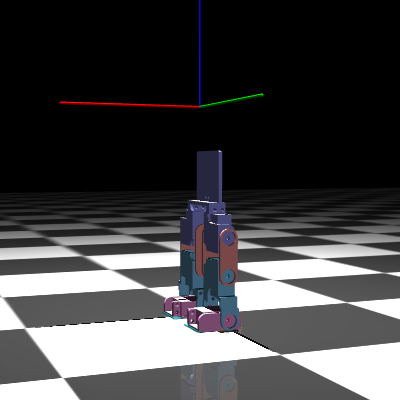

In [26]:
import numpy as np
import PIL.Image

np.random.seed(seed=42)

# Reset
env.reset()

# Step through 100 steps
for i in range(100):
    # Sample random actions in the allowed range
    # action = np.random.uniform(
    #     env.action_spec().minimum,
    #     env.action_spec().maximum,
    # )
    action = [0, 0, 0, 0, 0, 0]
    timestep = env.step(action)
    # print(timestep.observation.keys())
    # print(timestep.observation["joint_positions"]) # odict_keys(['biped/joint_positions', 'biped/joint_velocities'])

print(timestep)

# After 100 steps, render a frame
pixels = env.physics.render(camera_id=camera_mode, width=400, height=400)
PIL.Image.fromarray(pixels)

In [27]:
import gymnasium as gym
from dm_env import specs

class DmControlToGym(gym.Env):
    def __init__(self, dm_env):
        self._env = dm_env
        obs_spec = self._env.observation_spec()
        act_spec = self._env.action_spec()

        # Flatten observation dict to array
        from gymnasium.spaces import Box
        self.observation_space = Box(
            low=-np.inf, high=np.inf,
            shape=(sum(np.prod(v.shape) for v in obs_spec.values()),),
            dtype=np.float64,
        )
        self.action_space = Box(
            low=act_spec.minimum,
            high=act_spec.maximum,
            dtype=np.float64,
        )

    def reset(self, *, seed=None, options=None):
        timestep = self._env.reset()
        obs = self._flatten_obs(timestep.observation)
        return obs, {}

    def step(self, action):
        timestep = self._env.step(action)
        obs = self._flatten_obs(timestep.observation)
        reward = timestep.reward or 0.0
        terminated = timestep.last()
        truncated = False
        return obs, reward, terminated, truncated, {}

    def _flatten_obs(self, obs):
        return np.concatenate([v.ravel() for v in obs.values()])

In [28]:
import os
import cv2
import PIL.Image
import numpy as np
import imageio.v2 as imageio
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
from stable_baselines3.common.callbacks import BaseCallback

def save_video(frames, path="videos/eval.mp4", fps=60):
    """Save a list of frames (numpy arrays) to an MP4 file."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    imageio.mimsave(path, frames, fps=fps, macro_block_size=None)
    print(f"💾 Saved video: {path}")


class VideoEvalCallback(BaseCallback):
    def __init__(self, eval_env, eval_freq=10_000, framerate=30, smooth_window=10):
        super().__init__()
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.framerate = framerate
        self.smooth_window = smooth_window

    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            print(f"\n🎥  Recording full episode at training step {self.n_calls:,}...")
            self.record_full_episode()
        return True

    def record_full_episode(self):
        timestep = self.eval_env.reset()
        frames = []
        reward_buffer = deque(maxlen=self.smooth_window)

        while not timestep.last():
            # --- Policy action ---
            obs_vec = np.concatenate([v.ravel() for v in timestep.observation.values()])
            action, _ = self.model.predict(obs_vec, deterministic=True)
            timestep = self.eval_env.step(action)

            physics = self.eval_env.physics

            # --- Reward components ---
            comp = getattr(physics.data, "reward_components", {})
            total_reward = sum(comp.values()) if comp else 0.0
            reward_buffer.append(total_reward)

            # --- COM position and velocity ---
            com_pos = physics.data.qpos[:3].copy()
            com_vel = physics.data.qvel[:3].copy()

            # ---------- IMU + foot contact readings ----------
            imu_acc = imu_gyro = None
            left_contact = right_contact = None

            # Use current timestep.observation (after the step)
            obs_dict = timestep.observation

            # IMU: [accx, accy, accz, gyrox, gyroy, gyroz]
            if "biped/imu" in obs_dict:
                imu = obs_dict["biped/imu"].ravel()
                if imu.size >= 3:
                    imu_acc = imu[:3]
                if imu.size >= 6:
                    imu_gyro = imu[3:6]

            # Foot contacts: [left, right]
            contacts = obs_dict["foot_contacts"].ravel()
            left_contact, right_contact = contacts[0], contacts[1]
            # ------------------------------------------------------

            frame = physics.render(camera_id=camera_mode, width=600, height=400).copy()

            # --- Draw overlays ---
            avg_reward = np.mean(reward_buffer)
            y0, dy = 30, 25
            cv2.putText(frame, f"Avg reward (~0.33s): {avg_reward:6.3f}", (10, y0),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2, cv2.LINE_AA)

            # Reward components
            for i, (k, v) in enumerate(comp.items()):
                text = f"{k}: {v:+.3f}"
                cv2.putText(frame, text, (10, y0 + (i+1)*dy),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200,200,200), 1, cv2.LINE_AA)

            # COM overlays
            offset = y0 + (len(comp) + 2) * dy
            cv2.putText(frame, f"COM pos [x,y,z]: ({com_pos[0]:+.3f}, {com_pos[1]:+.3f}, {com_pos[2]:+.3f})",
                        (10, offset),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 1, cv2.LINE_AA)
            cv2.putText(frame, f"COM vel [x,y,z]: ({com_vel[0]:+.3f}, {com_vel[1]:+.3f}, {com_vel[2]:+.3f})",
                        (10, offset + dy),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 1, cv2.LINE_AA)

            # ---------- overlay IMU + contacts ----------
            extra_offset = offset + 2 * dy

            if imu_acc is not None:
                cv2.putText(frame,
                            f"IMU acc [x,y,z]: ({imu_acc[0]:+.2f}, {imu_acc[1]:+.2f}, {imu_acc[2]:+.2f})",
                            (10, extra_offset),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,200,255), 1, cv2.LINE_AA)
                extra_offset += dy

            if imu_gyro is not None:
                cv2.putText(frame,
                            f"IMU gyro [x,y,z]: ({imu_gyro[0]:+.2f}, {imu_gyro[1]:+.2f}, {imu_gyro[2]:+.2f})",
                            (10, extra_offset),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,200,255), 1, cv2.LINE_AA)
                extra_offset += dy

            if (left_contact is not None) and (right_contact is not None):
                cv2.putText(
                    frame,
                    f"Foot contact [L,R]: ({left_contact:5.2f}, {right_contact:5.2f})",
                    (10, extra_offset),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 1, cv2.LINE_AA
                )
            # ---------------------------------------------------

            frames.append(frame)

        save_video(
            frames,
            path=f"drive/MyDrive/biped/videos/episode_{self.n_calls}.mp4",
            fps=self.framerate,
        )


class PeriodicSaveCallback(BaseCallback):
    def __init__(self, save_freq, save_path, verbose=1):
        super().__init__(verbose)
        self.save_freq = save_freq
        self.save_path = save_path
        os.makedirs(save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.save_freq == 0:
            save_file = os.path.join(self.save_path, f"model_step_{self.n_calls}.zip")
            self.model.save(save_file)
            if self.verbose > 0:
                print(f"💾 Saved model at step {self.n_calls}: {save_file}")
        return True


In [29]:
# print(env.physics.model.ngeom)
print([env.physics.model.body(i).name for i in range(env.physics.model.nbody)])

for i in range(env.physics.model.nbody):
    print(f"{env.physics.model.body(i).name}: {env.physics.model.body(i).mass}kg")

['world', 'axis_indicator', 'biped', 'hips', 'left_connectors', 'left_leg', 'left_foot', 'right_connectors', 'right_leg', 'right_foot']
world: [0.]kg
axis_indicator: [0.]kg
biped: [0.]kg
hips: [0.3]kg
left_connectors: [0.01]kg
left_leg: [0.15]kg
left_foot: [0.05]kg
right_connectors: [0.01]kg
right_leg: [0.15]kg
right_foot: [0.05]kg


In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CallbackList

gym_env = DmControlToGym(env)

# Training environment
model = PPO("MlpPolicy", gym_env, verbose=1, tensorboard_log="./ppo_biped/")

# Evaluation environment (no randomization)
eval_env = env # reuse original dm_control environment

video_callback = VideoEvalCallback(
    eval_env=env,
    eval_freq=500_000
)

save_callback = PeriodicSaveCallback(
    save_freq=100_000,                 # Save every 100k steps
    save_path="drive/MyDrive/biped/checkpoints",
    verbose=1
)

callbacks = CallbackList([video_callback, save_callback])

# Train
model.learn(total_timesteps=5_000_000, callback=callbacks)
model.save("ppo_biped_model")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_biped/PPO_2


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 625      |
|    ep_rew_mean     | -277     |
| time/              |          |
|    fps             | 570      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 677         |
|    ep_rew_mean          | -281        |
| time/                   |             |
|    fps                  | 474         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008822223 |
|    clip_fraction        | 0.0924      |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.51       |
|    explained_variance   | -0.0127     |
|    learning_rate        | 0.

# Test Manual Policy

In [16]:
import numpy as np

# -------------------------------------------------------------------
# Constants – tune these to match your `constants.h` as closely as possible
# -------------------------------------------------------------------
# These numbers are directly inspired by your Arduino code
L1 = 5.0              # upper leg length (same scale as your hardware l1)
L2 = 5.0              # lower leg length (hardware l2)
INIT_Z = 10.7         # start height from initialize()
STEP_HEIGHT = 9.0     # stepHeight in your Arduino code
STEP_CLEARANCE = 1.0  # stepClearance in your Arduino code
STEP_LENGTH = 2.0     # takeStep(2, 0)

# Discretization of the Arduino for-loops
INIT_DZ = 0.1         # initialize: for (z = 10.7; z >= stepHeight; z -= 0.1)
STEP_DX = 0.5         # takeStep: for (i = stepLength; i >= -stepLength; i -= 0.5)

# Precompute some counts
N_INIT_STEPS = int(round((INIT_Z - STEP_HEIGHT) / INIT_DZ)) + 1  # inclusive
N_WALK_SEG = int(round((STEP_LENGTH - (-STEP_LENGTH)) / STEP_DX)) + 1
N_CYCLE = 2 * N_WALK_SEG  # two loops per takeStep
# -------------------------------------------------------------------


def _leg_ik(x, z, l1=L1, l2=L2):
    """
    Inverse kinematics for one leg, directly mirroring your Arduino `pos`:
        hipRad2 = atan(x/z)
        z2      = z / cos(hipRad2)
        hipRad1 = acos((l1^2 + z2^2 - l2^2) / (2*l1*z2))
        kneeRad = PI - acos((l1^2 + l2^2 - z2^2) / (2*l1*l2))
        ankleRad = PI/2 + hipRad2 - acos((l2^2 + z2^2 - l1^2) / (2*l2*z2))
        hipRad  = hipRad1 + hipRad2
    Returns (hip, knee, ankle) in radians.
    """
    # Avoid division by zero
    if abs(z) < 1e-6:
        z = np.sign(z) * 1e-6 if z != 0 else 1e-6

    hipRad2 = np.arctan2(x, z)  # atan(x/z) but with quadrants
    # avoid cos(hipRad2) = 0
    c = np.cos(hipRad2)
    if abs(c) < 1e-6:
        c = np.sign(c) * 1e-6 if c != 0 else 1e-6

    z2 = z / c

    # Helper to keep acos argument in [-1, 1]
    def safe_acos(arg):
        return np.arccos(np.clip(arg, -1.0, 1.0))

    hipRad1 = safe_acos((l1**2 + z2**2 - l2**2) / (2.0 * l1 * z2))
    kneeRad = np.pi - safe_acos((l1**2 + l2**2 - z2**2) / (2.0 * l1 * l2))
    ankleRad = (np.pi / 2.0) + hipRad2 - safe_acos((l2**2 + z2**2 - l1**2) / (2.0 * l2 * z2))

    hipRad = hipRad1 + hipRad2
    return hipRad, kneeRad, ankleRad


def _gait_targets(step_idx):
    """
    Recreates your Arduino timing as a function of integer step_idx.

    1. initialize():
         for (z = 10.7; z >= stepHeight; z -= 0.1) { pos(0, z, 'l'); pos(0, z, 'r'); }
    2. Repeating takeStep(2, 0):
         for (i =  stepLength; i >= -stepLength; i -= 0.5) {
             pos(i,  stepHeight,               'r');
             pos(-i, stepHeight - stepClearance, 'l');
         }
         for (i =  stepLength; i >= -stepLength; i -= 0.5) {
             pos(-i, stepHeight - stepClearance, 'r');
             pos(i,  stepHeight,                 'l');
         }

    Returns (xL, zL, xR, zR).
    """

    # --- Phase 1: initialize ---
    if step_idx < N_INIT_STEPS:
        # linearly step from INIT_Z -> STEP_HEIGHT
        frac = step_idx / max(N_INIT_STEPS - 1, 1)
        z = INIT_Z + frac * (STEP_HEIGHT - INIT_Z)
        x = 0.0
        return x, z, x, z

    # --- Phase 2+: walking: cyclic takeStep ---
    idx = step_idx - N_INIT_STEPS
    phase = idx % N_CYCLE

    # i goes stepLength -> -stepLength in N_WALK_SEG steps
    # k in [0, N_WALK_SEG-1] -> i = stepLength - k * STEP_DX
    if phase < N_WALK_SEG:
        # first for-loop
        k = phase
        i = STEP_LENGTH - k * STEP_DX
        xR, zR = i, STEP_HEIGHT
        xL, zL = -i, STEP_HEIGHT - STEP_CLEARANCE
    else:
        # second for-loop
        k = phase - N_WALK_SEG
        i = STEP_LENGTH - k * STEP_DX
        xR, zR = -i, STEP_HEIGHT - STEP_CLEARANCE
        xL, zL = i, STEP_HEIGHT

    return xL, zL, xR, zR


def manual_policy(timestep, step_idx, env):
    """
    Handcrafted policy that mimics your Arduino gait:
      - same IK equations as `pos(x,z,leg)`
      - same initialize() and takeStep(2,0) sequencing (discretized)
    Returns an action vector matching env.action_spec().
    """
    act_spec = env.action_spec()

    # 1) Compute (x,z) for each leg according to Arduino loops
    xL, zL, xR, zR = _gait_targets(step_idx)

    # 2) Inverse kinematics: (hip, knee, ankle) for each leg, in radians
    hipL, kneeL, ankleL = _leg_ik(xL, zL)
    hipR, kneeR, ankleR = _leg_ik(xR, zR)

    # 3) Map to action vector.
    # We assume 6 actuators in this order: [hipL, kneeL, ankleL, hipR, kneeR, ankleR]
    # If your XML uses a different order, just reorder this array.
    action = np.array(
        [hipL, kneeL, ankleL, hipR, kneeR, ankleR],
        dtype=np.float64,
    )

    # Optional: scale down if needed (MuJoCo ctrlrange might be smaller than leg angles)
    # For a start we can leave it unscaled and rely on clipping below.
    # scale = 1.0
    # action *= scale

    # 4) Clip to actuator limits
    action = np.clip(action, act_spec.minimum, act_spec.maximum)

    return action

In [17]:
from collections import deque
import cv2
import numpy as np

def record_manual_episode(eval_env,
                          framerate=30,
                          smooth_window=10,
                          out_path="drive/MyDrive/biped/videos/manual_policy_episode.mp4"):
    """
    Run one full episode in eval_env using manual_policy(...) and
    save a video with all the overlays.
    """
    timestep = eval_env.reset()
    frames = []
    reward_buffer = deque(maxlen=smooth_window)
    step_idx = 0

    while not timestep.last():
        # --------- handcrafted policy action ----------
        action = manual_policy(timestep, step_idx, eval_env)
        timestep = eval_env.step(action)
        step_idx += 1
        # ----------------------------------------------

        physics = eval_env.physics

        # --- Reward components ---
        comp = getattr(physics.data, "reward_components", {})
        total_reward = sum(comp.values()) if comp else 0.0
        reward_buffer.append(total_reward)

        # --- COM position and velocity ---
        com_pos = physics.data.qpos[:3].copy()
        com_vel = physics.data.qvel[:3].copy()

        # ---------- IMU + foot contact readings ----------
        imu_acc = imu_gyro = None
        left_contact = right_contact = None

        obs_dict = timestep.observation

        # IMU: [accx, accy, accz, gyrox, gyroy, gyroz]
        if "biped/imu" in obs_dict:
            imu = obs_dict["biped/imu"].ravel()
            if imu.size >= 3:
                imu_acc = imu[:3]
            if imu.size >= 6:
                imu_gyro = imu[3:6]

        # Foot contacts: [left, right]
        if "foot_contacts" in obs_dict:
            contacts = obs_dict["foot_contacts"].ravel()
            if contacts.size >= 2:
                left_contact, right_contact = contacts[0], contacts[1]
        # ------------------------------------------------------

        frame = physics.render(camera_id=camera_mode, width=600, height=400).copy()

        # --- Draw overlays (same as in your callback) ---
        avg_reward = np.mean(reward_buffer)
        y0, dy = 30, 25
        cv2.putText(frame, f"Avg reward (~0.33s): {avg_reward:6.3f}", (10, y0),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2, cv2.LINE_AA)

        # Reward components
        for i, (k, v) in enumerate(comp.items()):
            text = f"{k}: {v:+.3f}"
            cv2.putText(frame, text, (10, y0 + (i+1)*dy),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200,200,200), 1, cv2.LINE_AA)

        # COM overlays
        offset = y0 + (len(comp) + 2) * dy
        cv2.putText(frame, f"COM pos [x,y,z]: ({com_pos[0]:+.3f}, {com_pos[1]:+.3f}, {com_pos[2]:+.3f})",
                    (10, offset),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 1, cv2.LINE_AA)
        cv2.putText(frame, f"COM vel [x,y,z]: ({com_vel[0]:+.3f}, {com_vel[1]:+.3f}, {com_vel[2]:+.3f})",
                    (10, offset + dy),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 1, cv2.LINE_AA)

        # ---------- overlay IMU + contacts ----------
        extra_offset = offset + 2 * dy

        if imu_acc is not None:
            cv2.putText(frame,
                        f"IMU acc [x,y,z]: ({imu_acc[0]:+.2f}, {imu_acc[1]:+.2f}, {imu_acc[2]:+.2f})",
                        (10, extra_offset),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,200,255), 1, cv2.LINE_AA)
            extra_offset += dy

        if imu_gyro is not None:
            cv2.putText(frame,
                        f"IMU gyro [x,y,z]: ({imu_gyro[0]:+.2f}, {imu_gyro[1]:+.2f}, {imu_gyro[2]:+.2f})",
                        (10, extra_offset),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,200,255), 1, cv2.LINE_AA)
            extra_offset += dy

        if (left_contact is not None) and (right_contact is not None):
            cv2.putText(
                frame,
                f"Foot contact [L,R]: ({left_contact:5.2f}, {right_contact:5.2f})",
                (10, extra_offset),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 1, cv2.LINE_AA
            )
        # ---------------------------------------------------

        frames.append(frame)

    save_video(frames, path=out_path, fps=framerate)
    print("✅ Finished manual policy episode.")

In [20]:
out_path="drive/MyDrive/biped/videos/manual_policy_episode.mp4"

# Build env as in your dm_biped file
robot = Biped(xml_path="drive/MyDrive/biped/model.xml")
task = WalkingTask(robot)
env = composer.Environment(task=task, time_limit=10,
                           random_state=np.random.RandomState())

# Record **one** full episode of the handcrafted policy
record_manual_episode(env,
                      framerate=30,
                      out_path=out_path)

💾 Saved video: drive/MyDrive/biped/videos/manual_policy_episode.mp4
✅ Finished manual policy episode.


In [21]:
from IPython.display import Video

Video(out_path, embed=True)
